In [1]:
import os
import sys
sys.path.append('/Users/julnow/gsi/ml-pid-cbm')
from ml_pid_cbm.tools import json_tools, plotting_tools
from hipe4ml.model_handler import ModelHandler
import fasttreeshap as shap
import pandas as pd
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/cbm22/lib/python3.8/site-packages/fasttreeshap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/Caskroom/miniforge/base/envs/cbm22/lib/python3.8/site-packages/fasttreeshap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-whe

In [2]:
json_file_name ="config.json"
model_name = "model_0.0_1.6_positive"
model_dir = f"/Users/julnow/gsi/ml-pid-cbm/ml_pid_cbm/only_tof/mass2/noweights_hyper/{model_name}"
os.chdir(model_dir)
df = pd.read_pickle(f"{model_dir}/validated_data.pickle")


Let's check xgb-selected proton in the first bin, from p =0-1.6 GeV/c

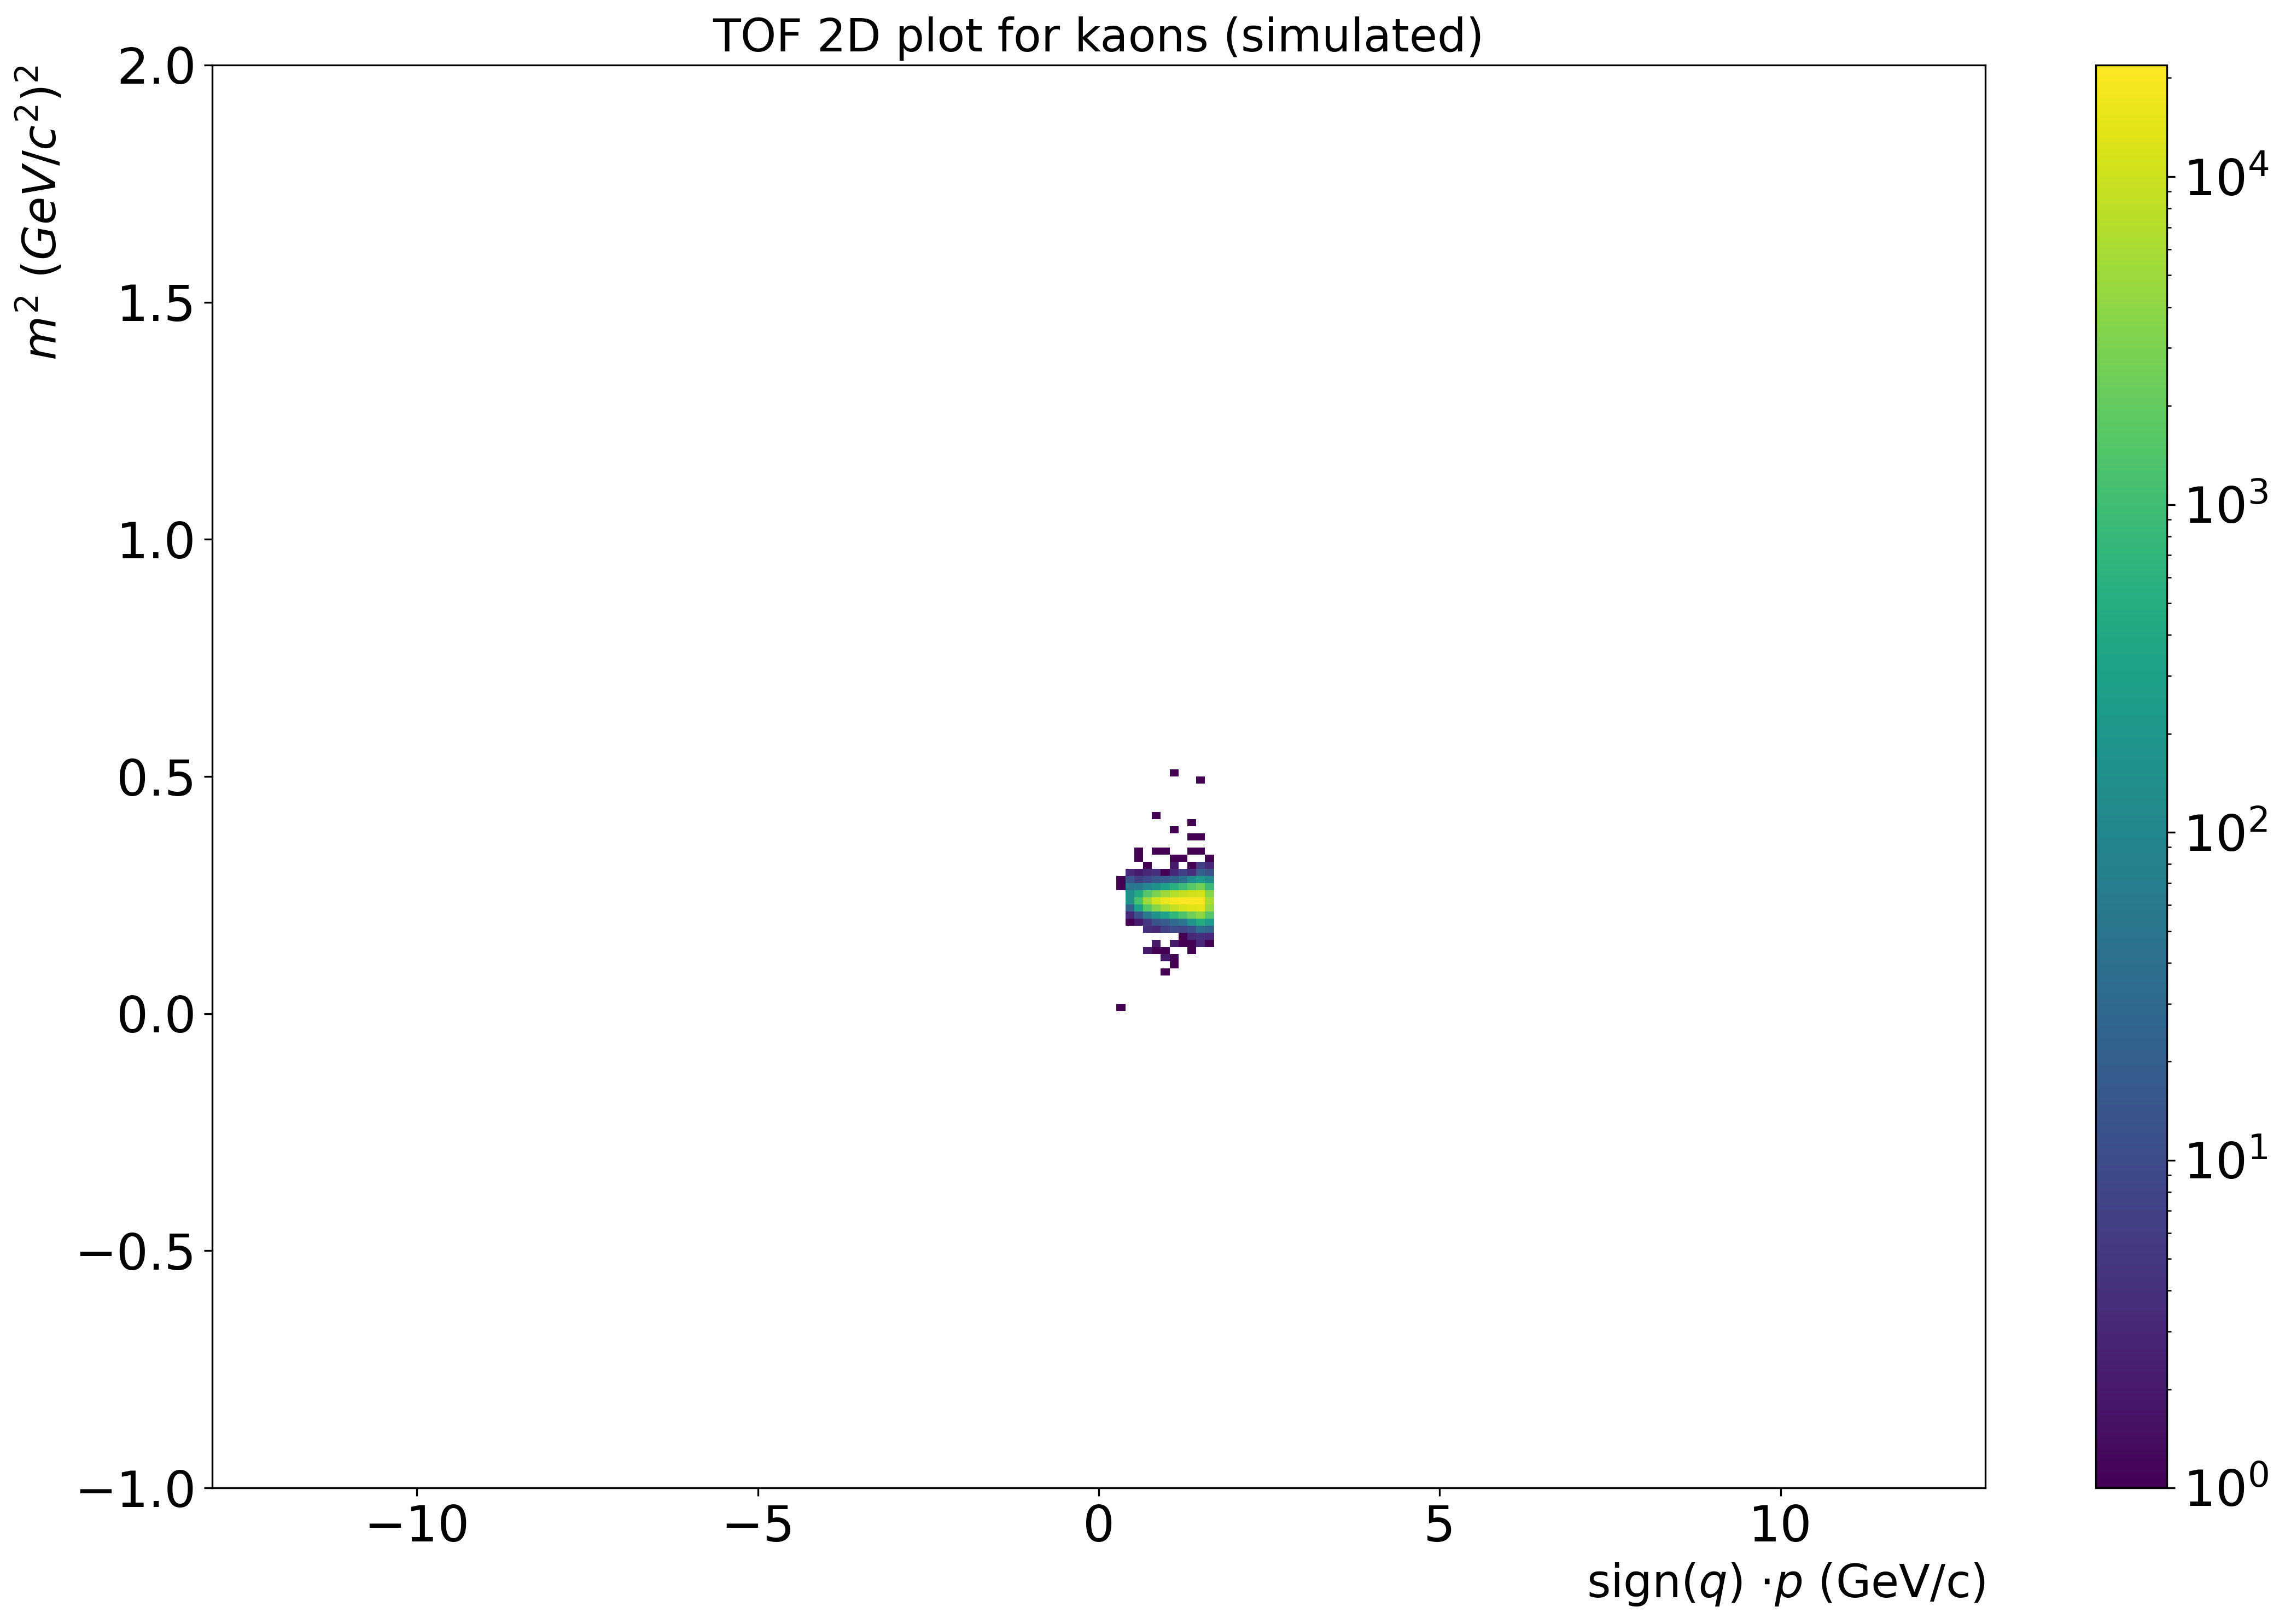

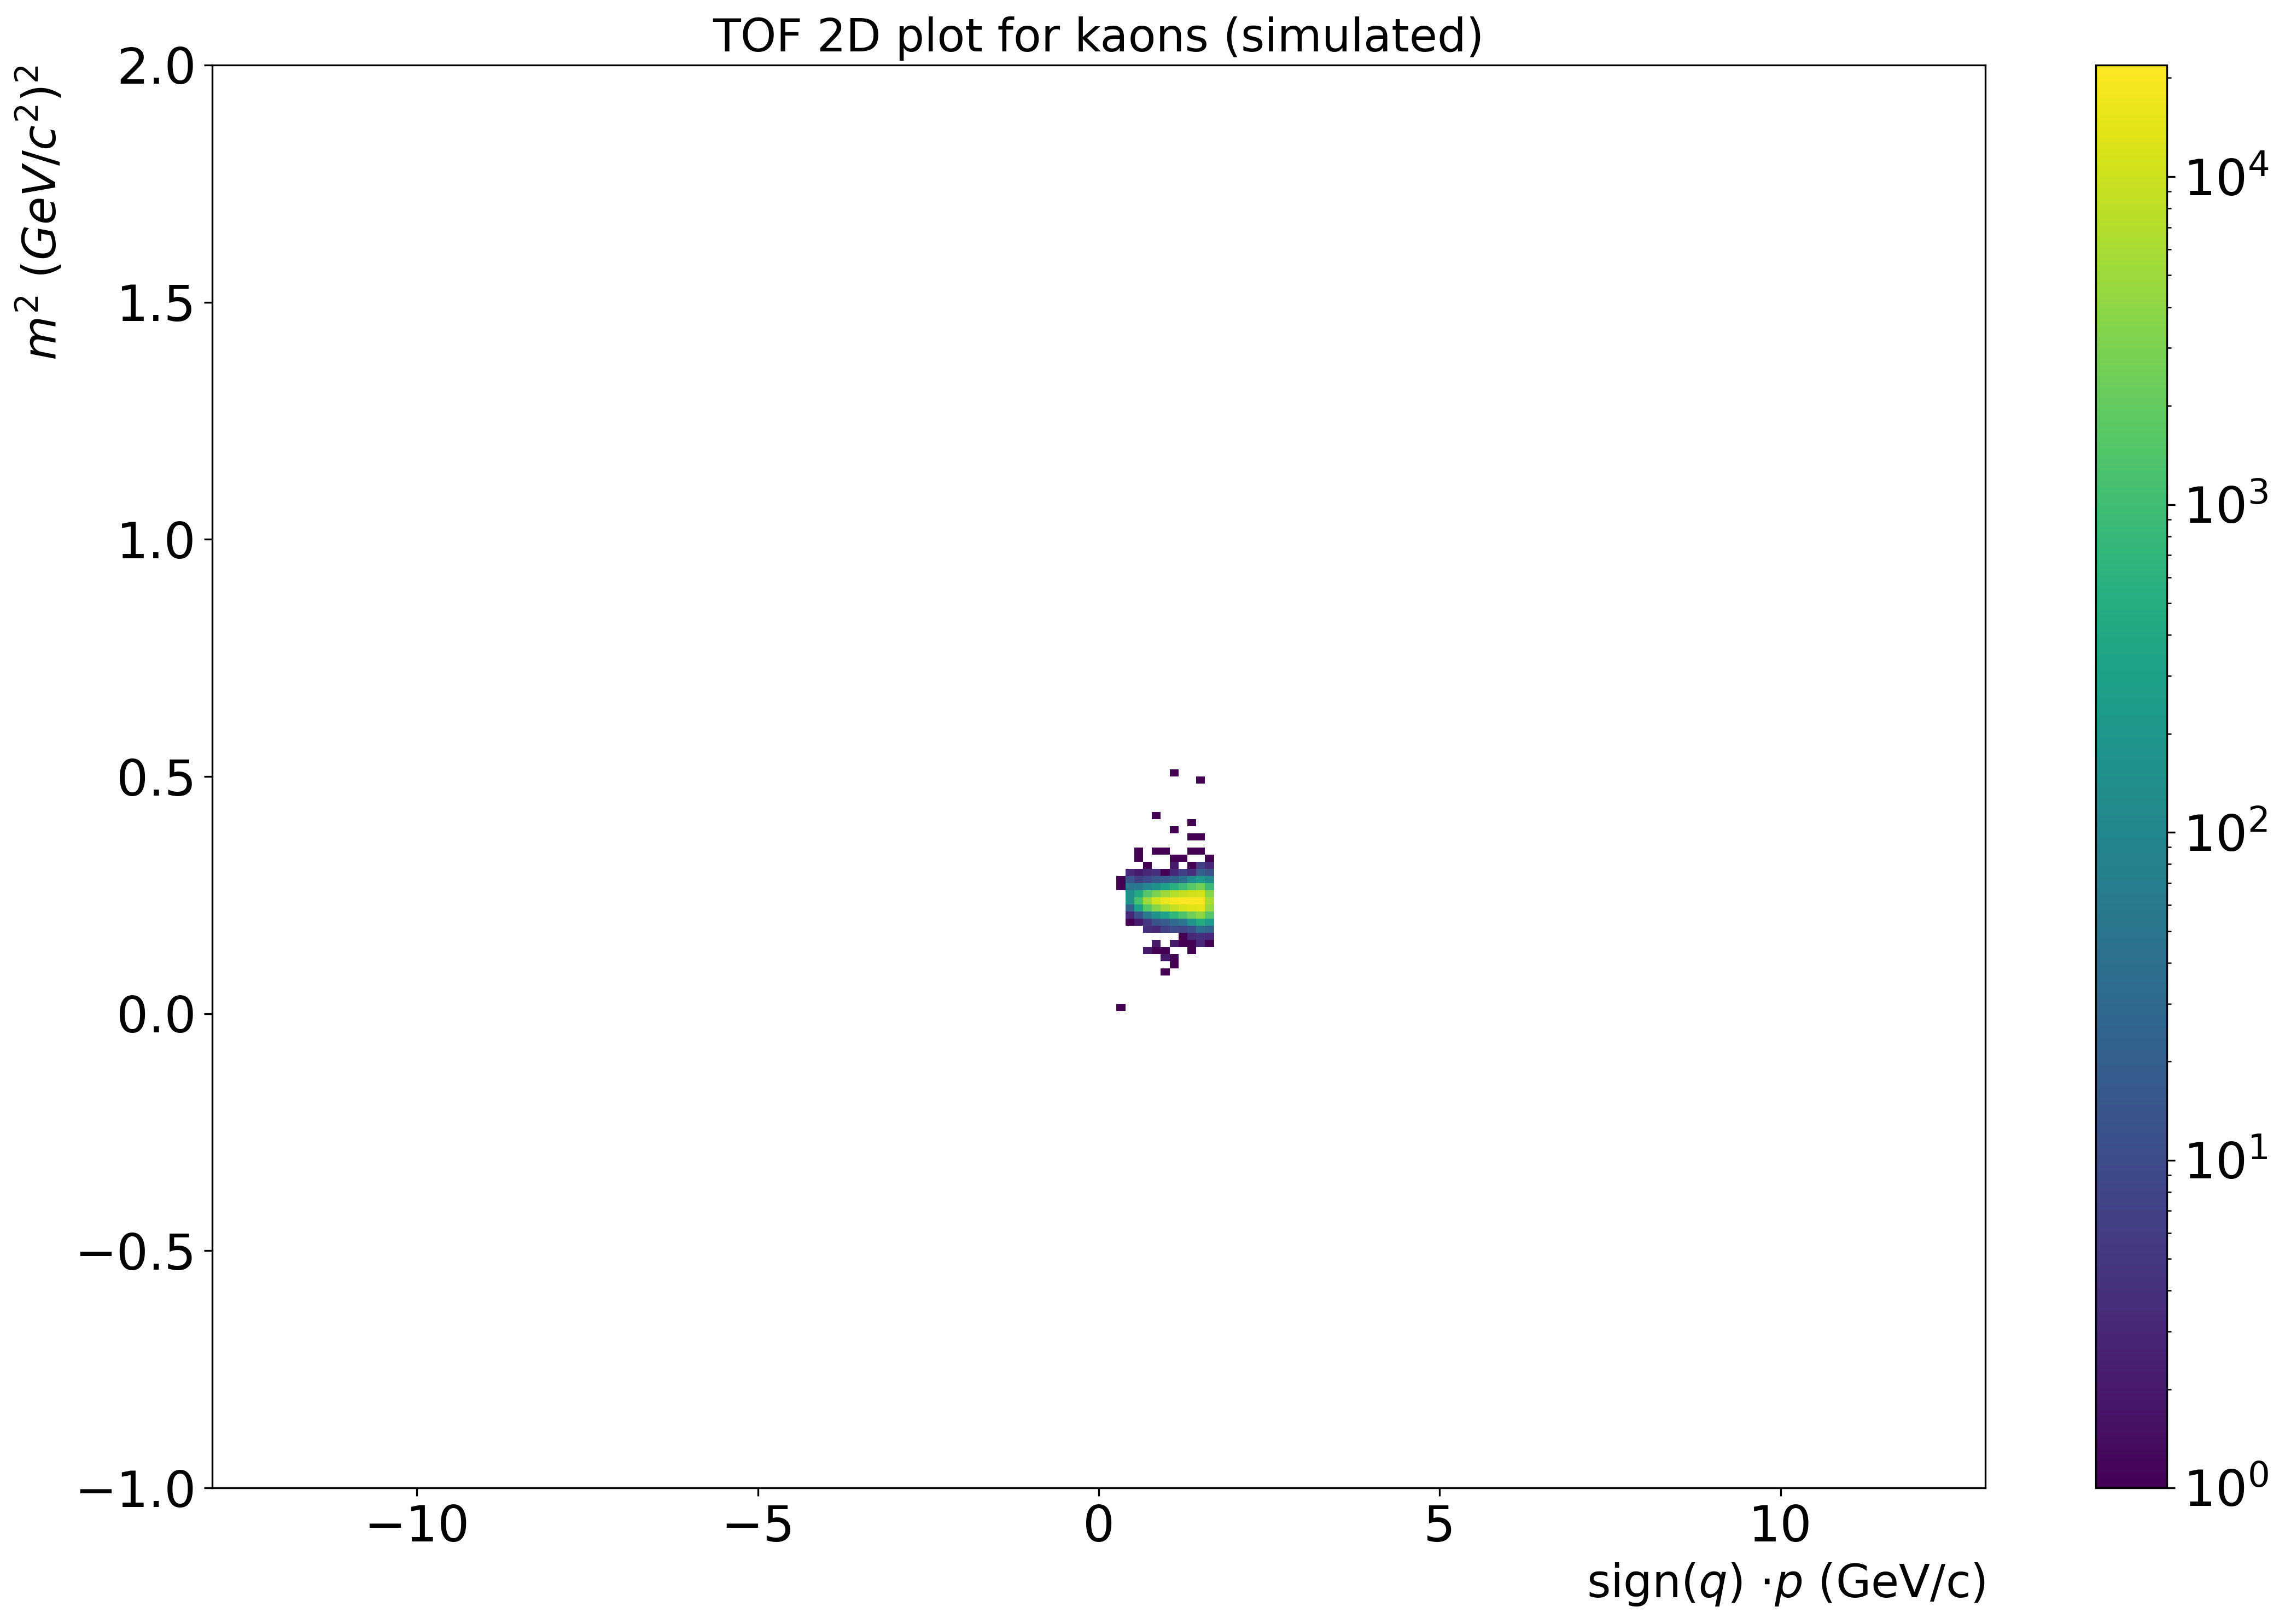

In [3]:
plotting_tools.tof_plot(
            df[df["Complex_pid"] == 1],
            json_file_name,
            f"kaons (simulated)",
            save_fig=False,
        )

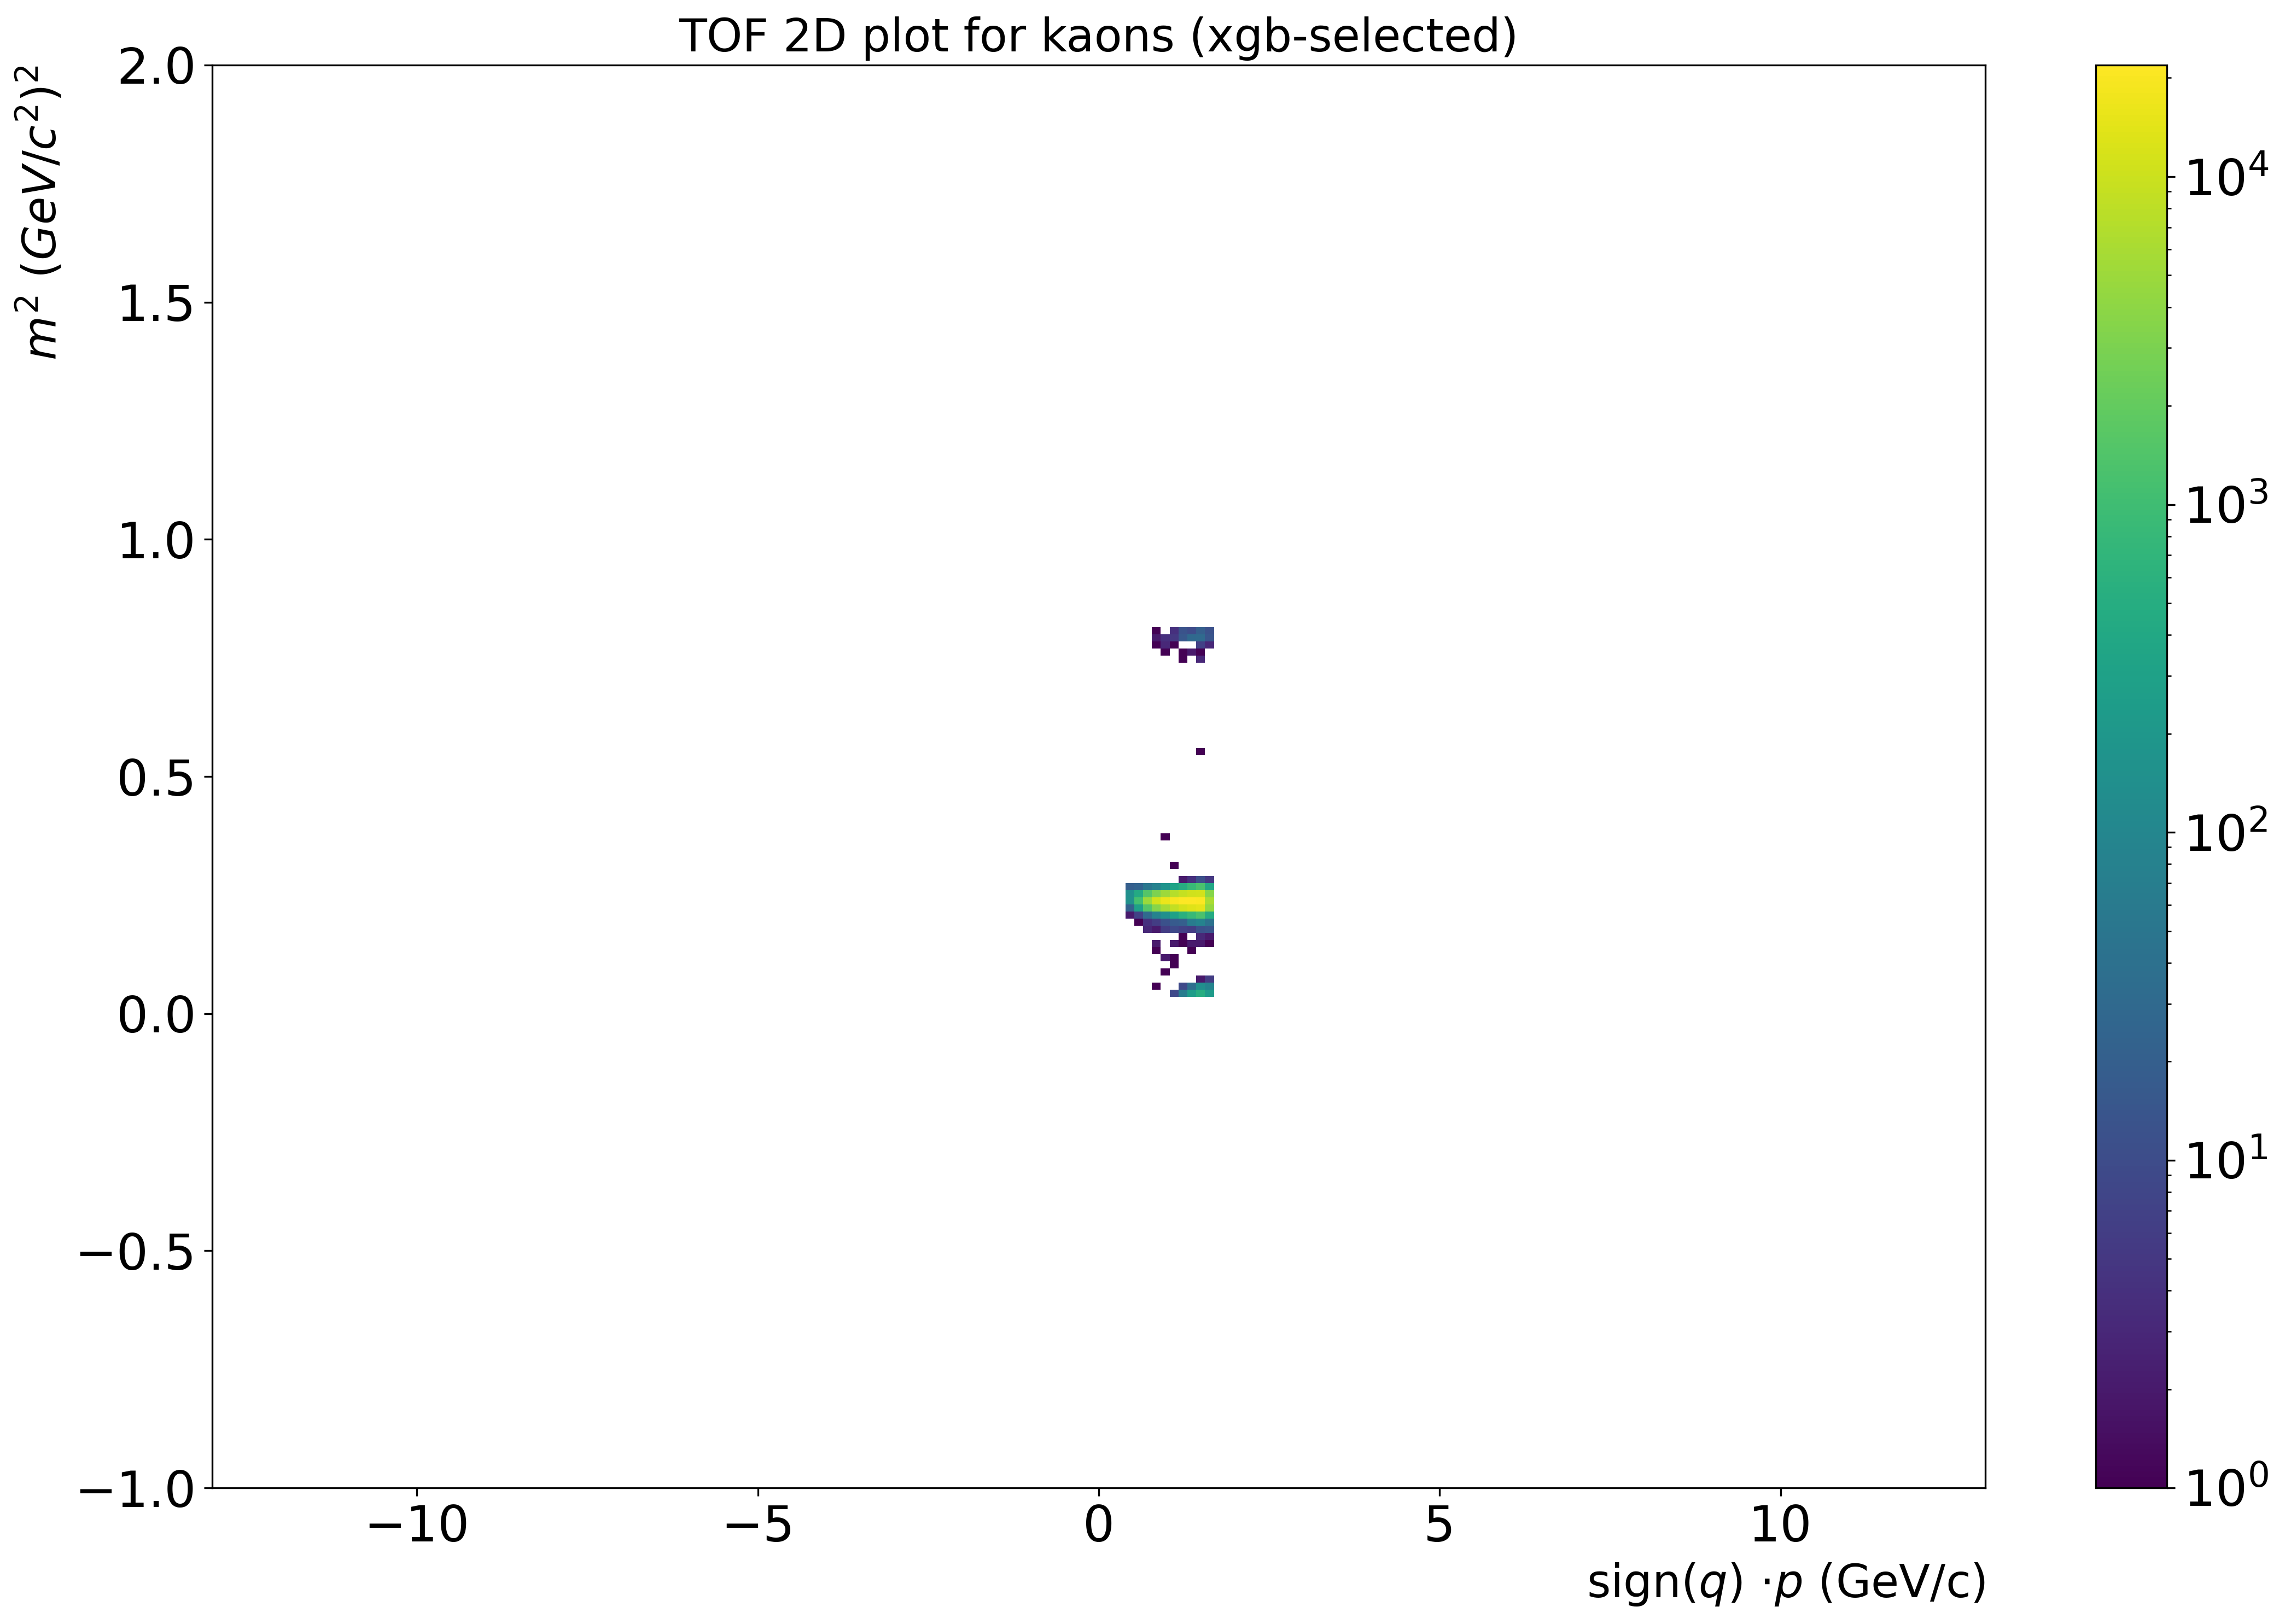

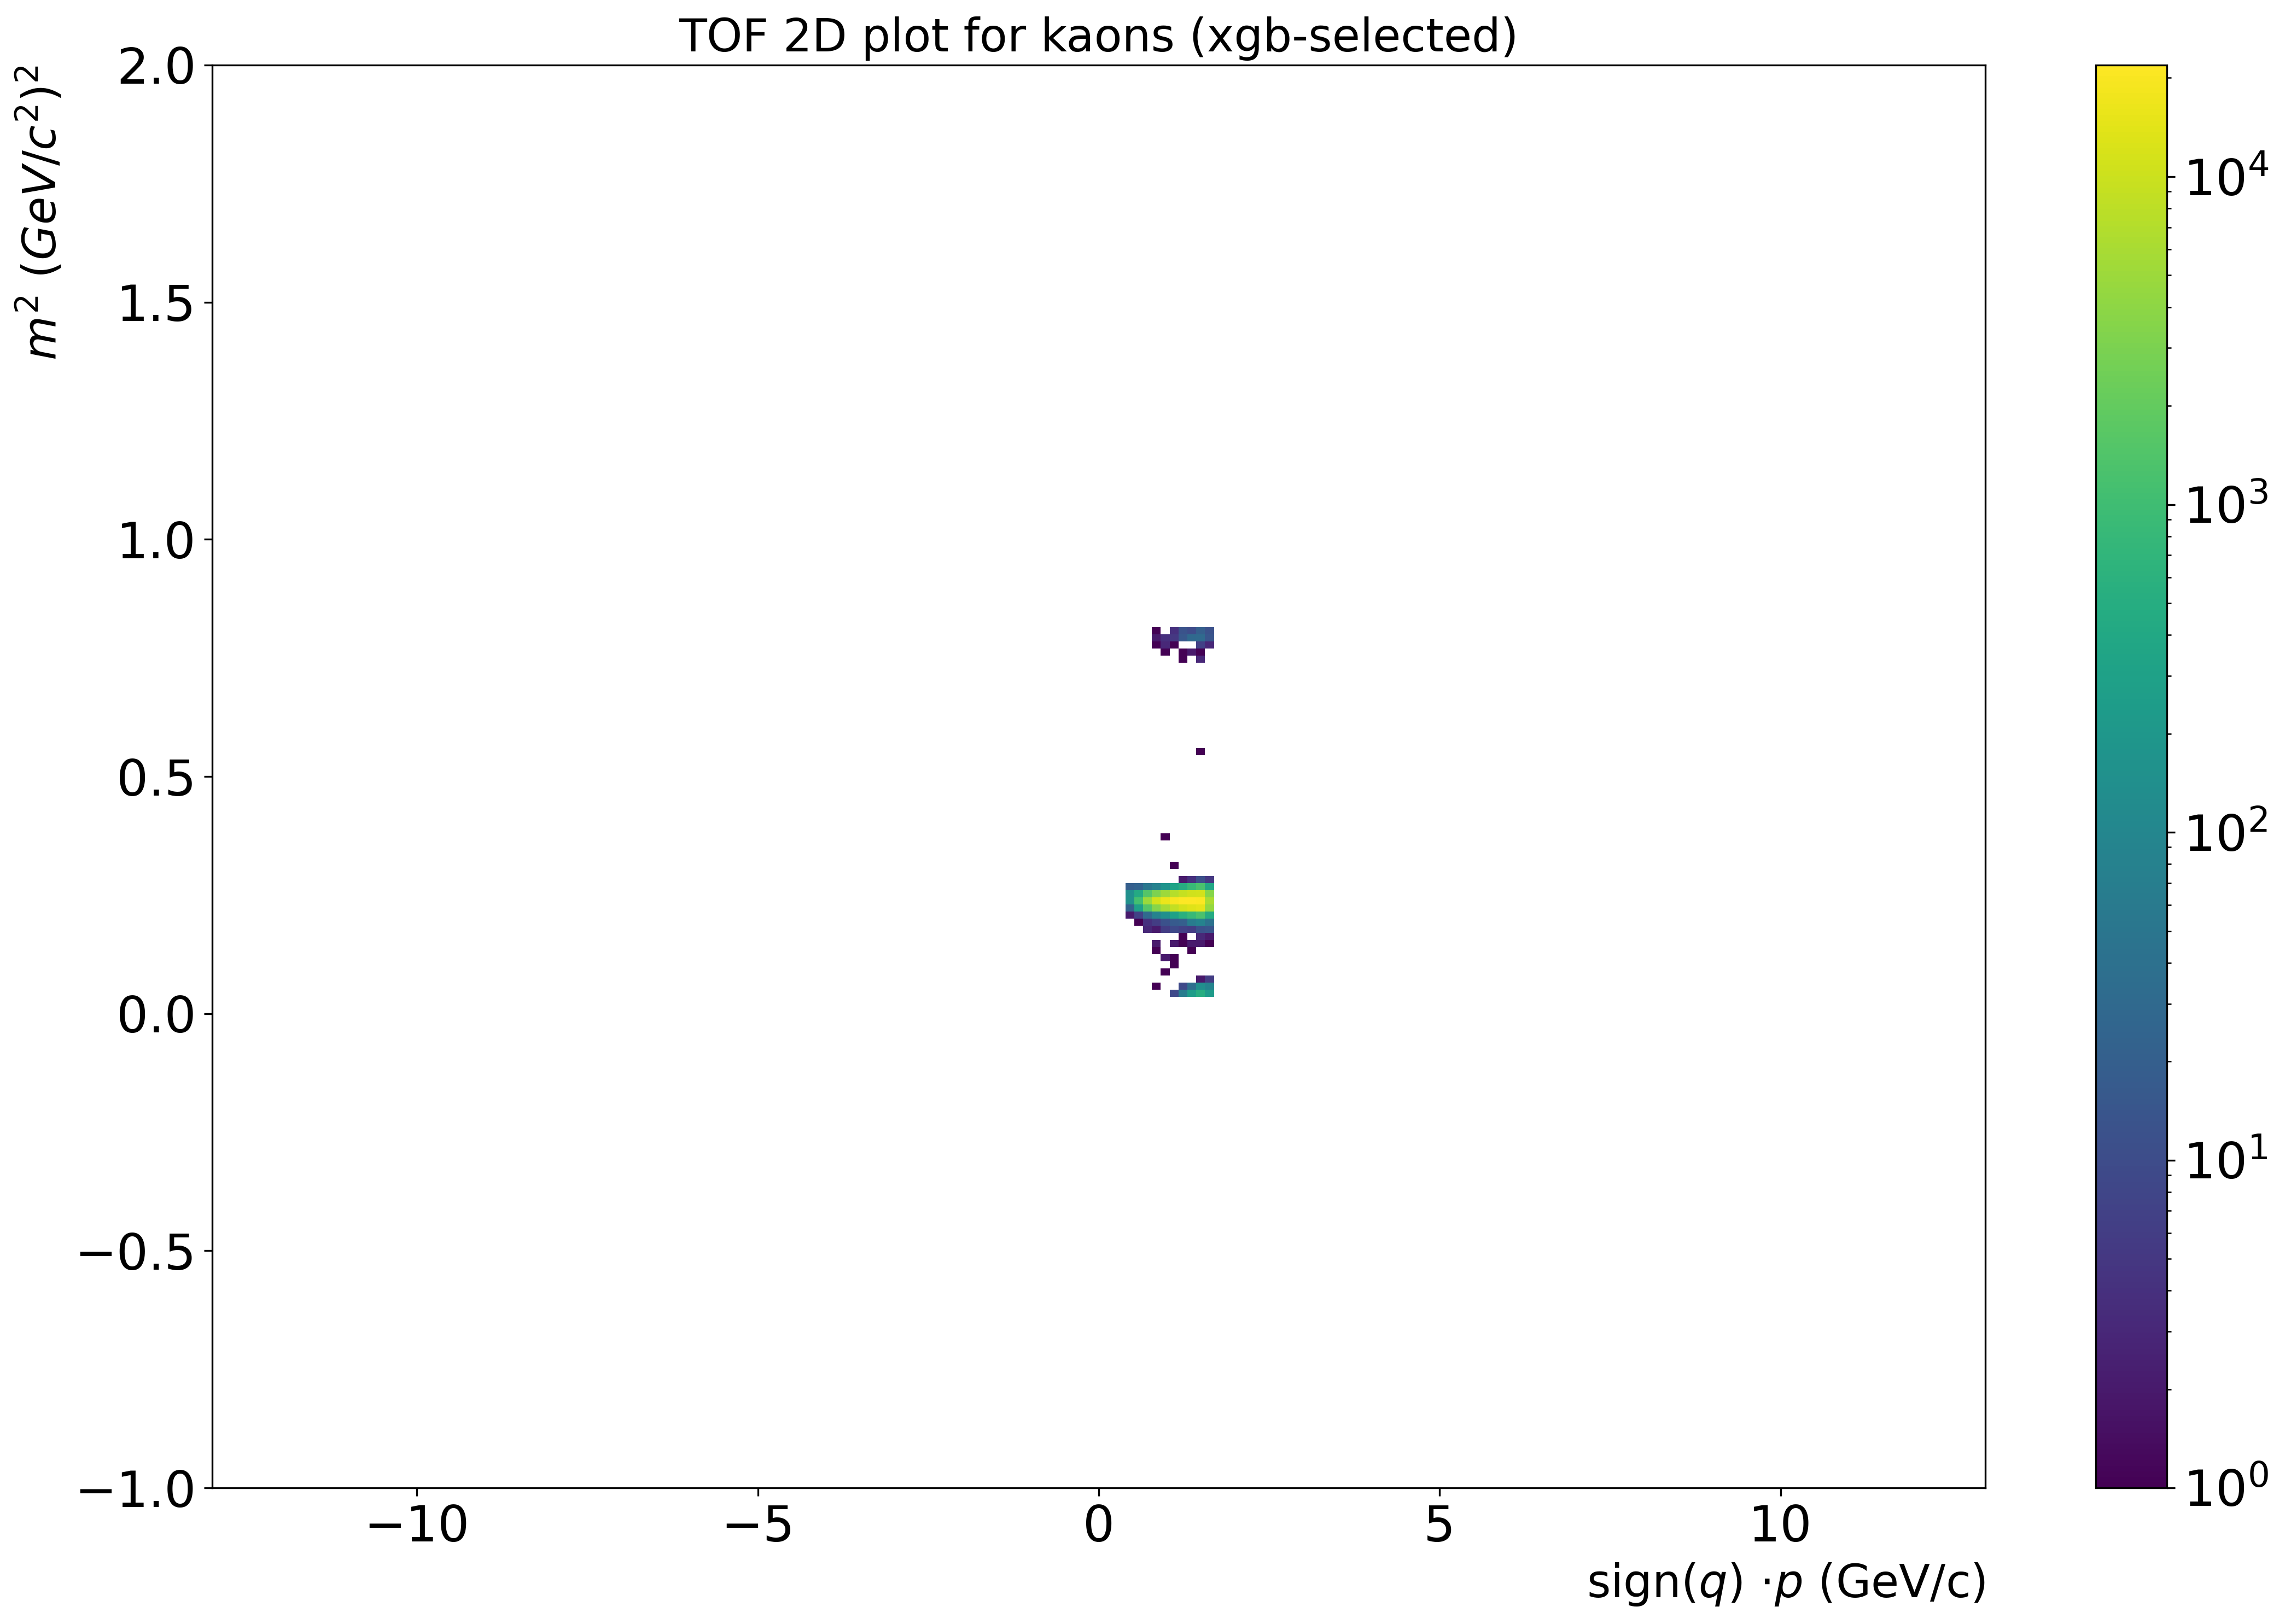

In [6]:
plotting_tools.tof_plot(
            df[df["xgb_preds"] == 1],
            json_file_name,
            f"kaons (xgb-selected)",
            save_fig=False,
        )

Let's take a closer look at xgb-selected kaons with $$mass^2 > 0.5$$ which are MC-true protons

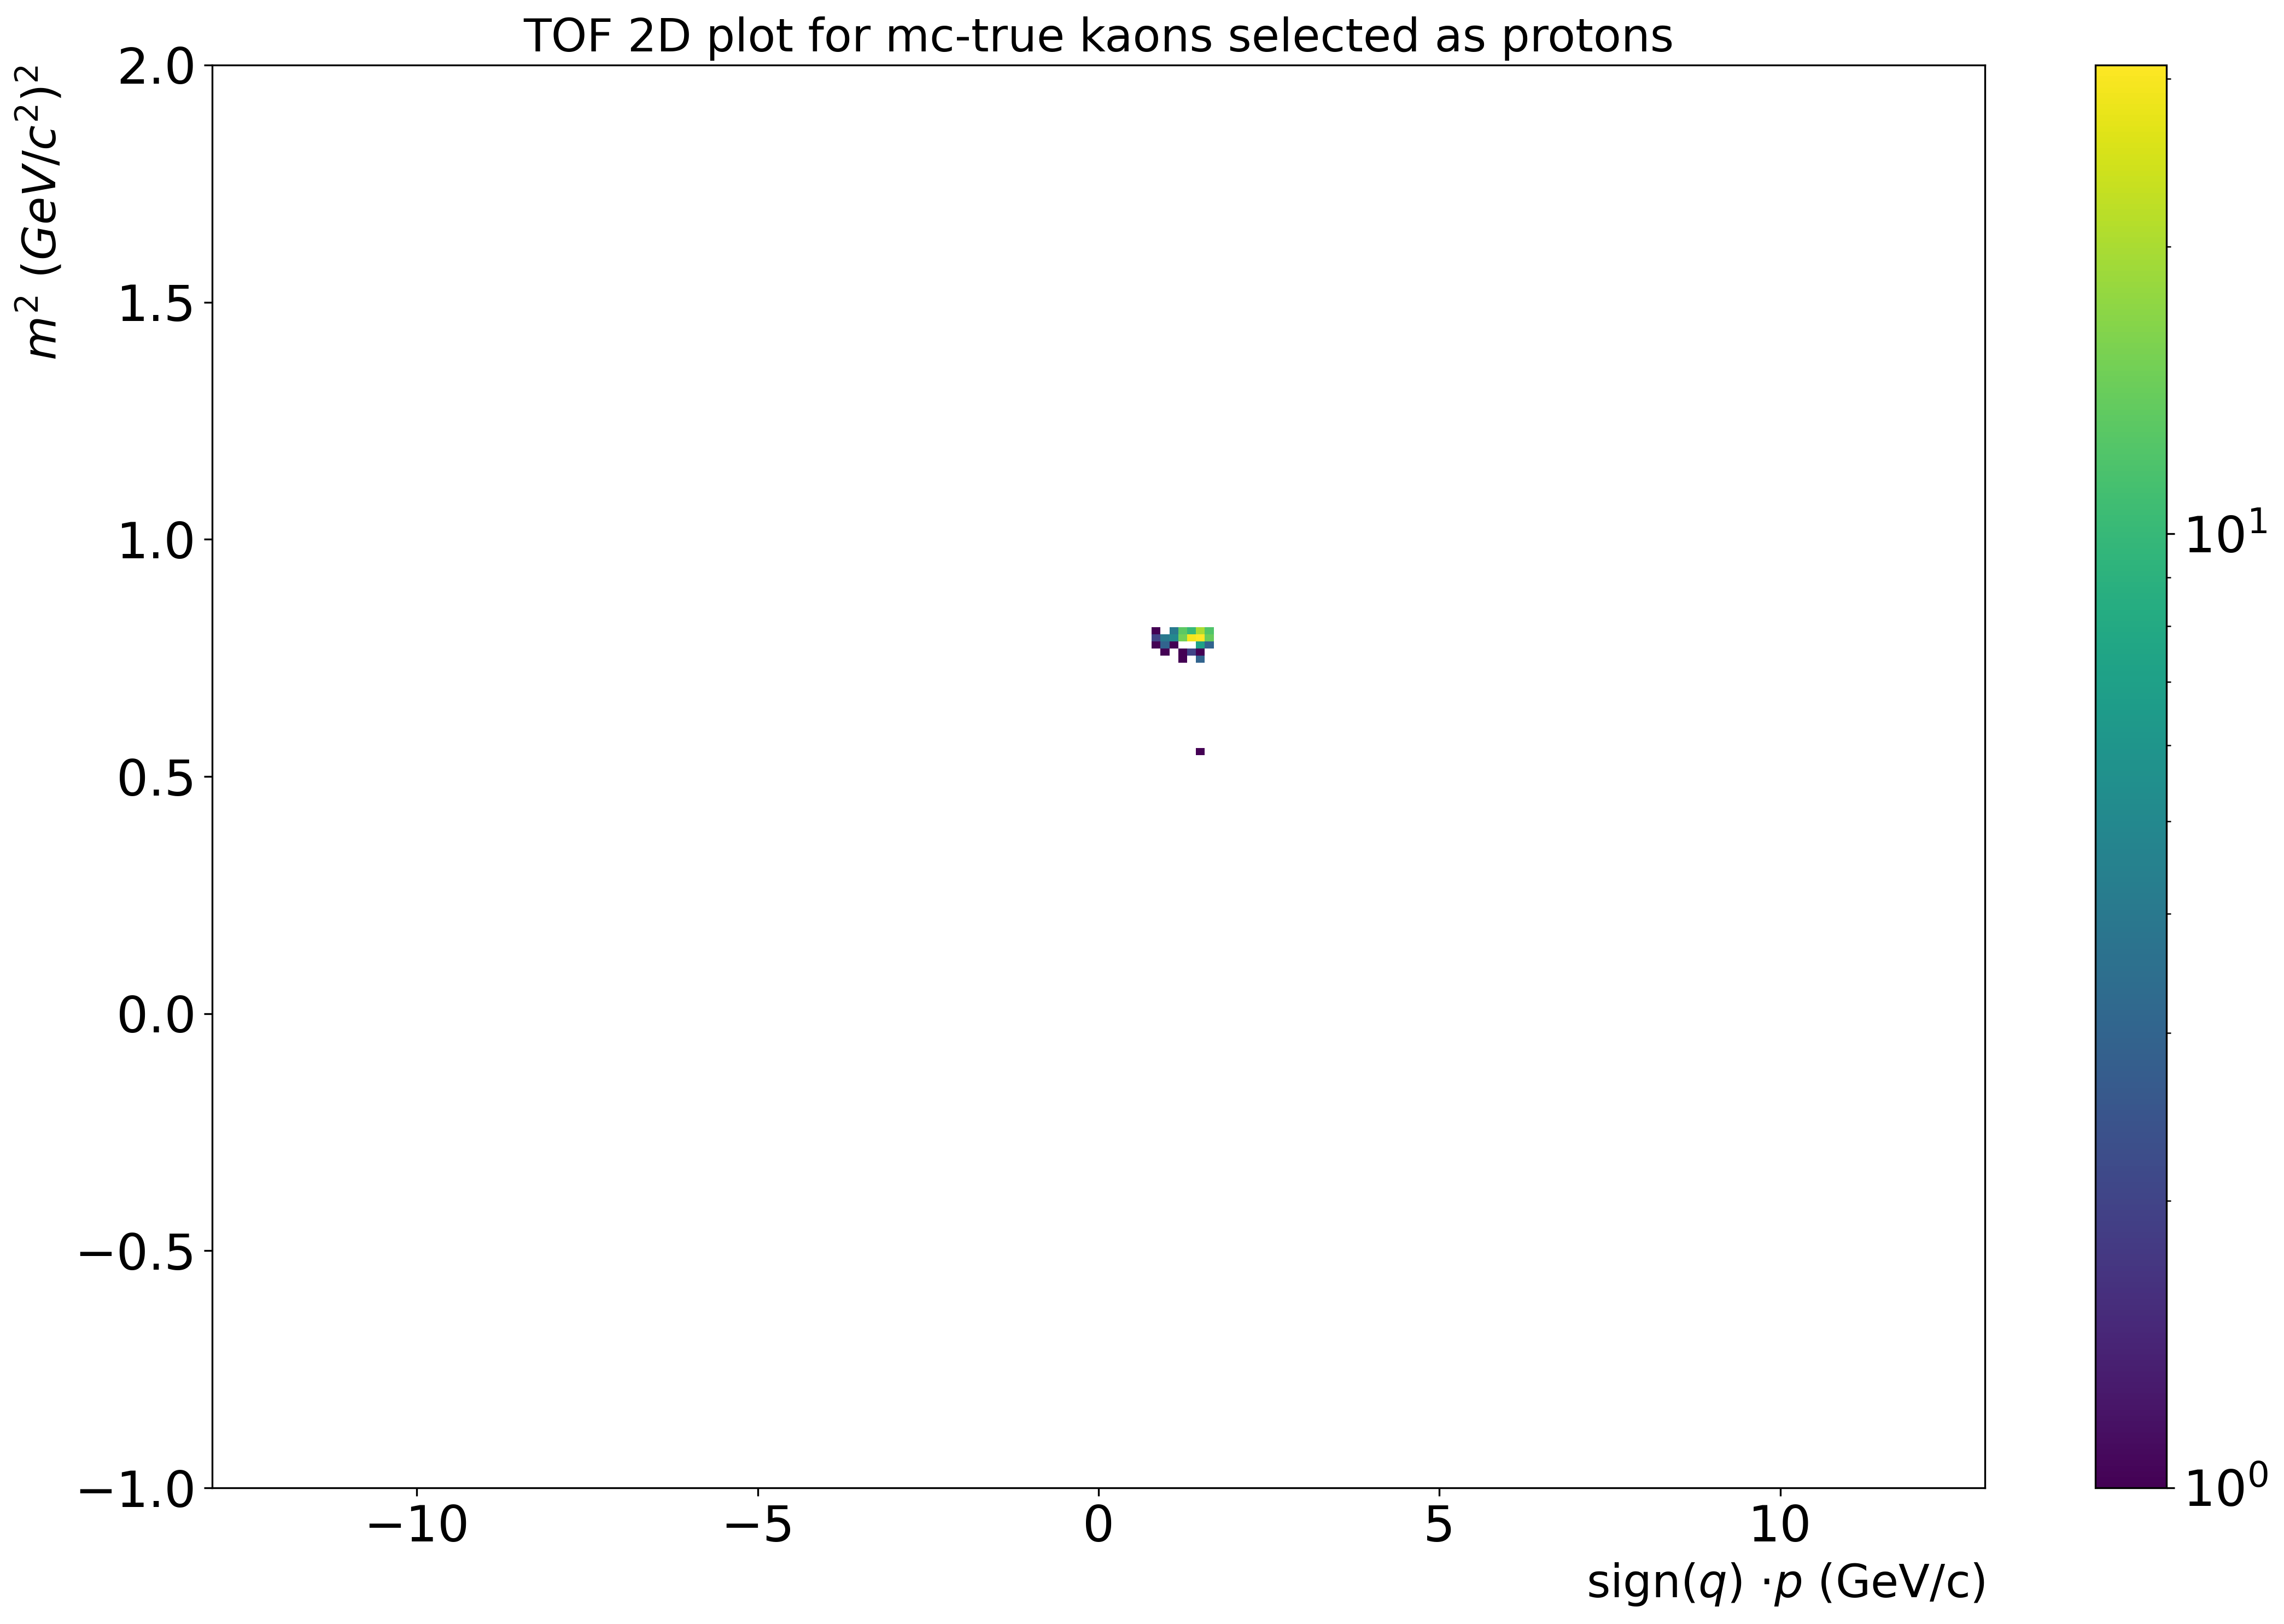

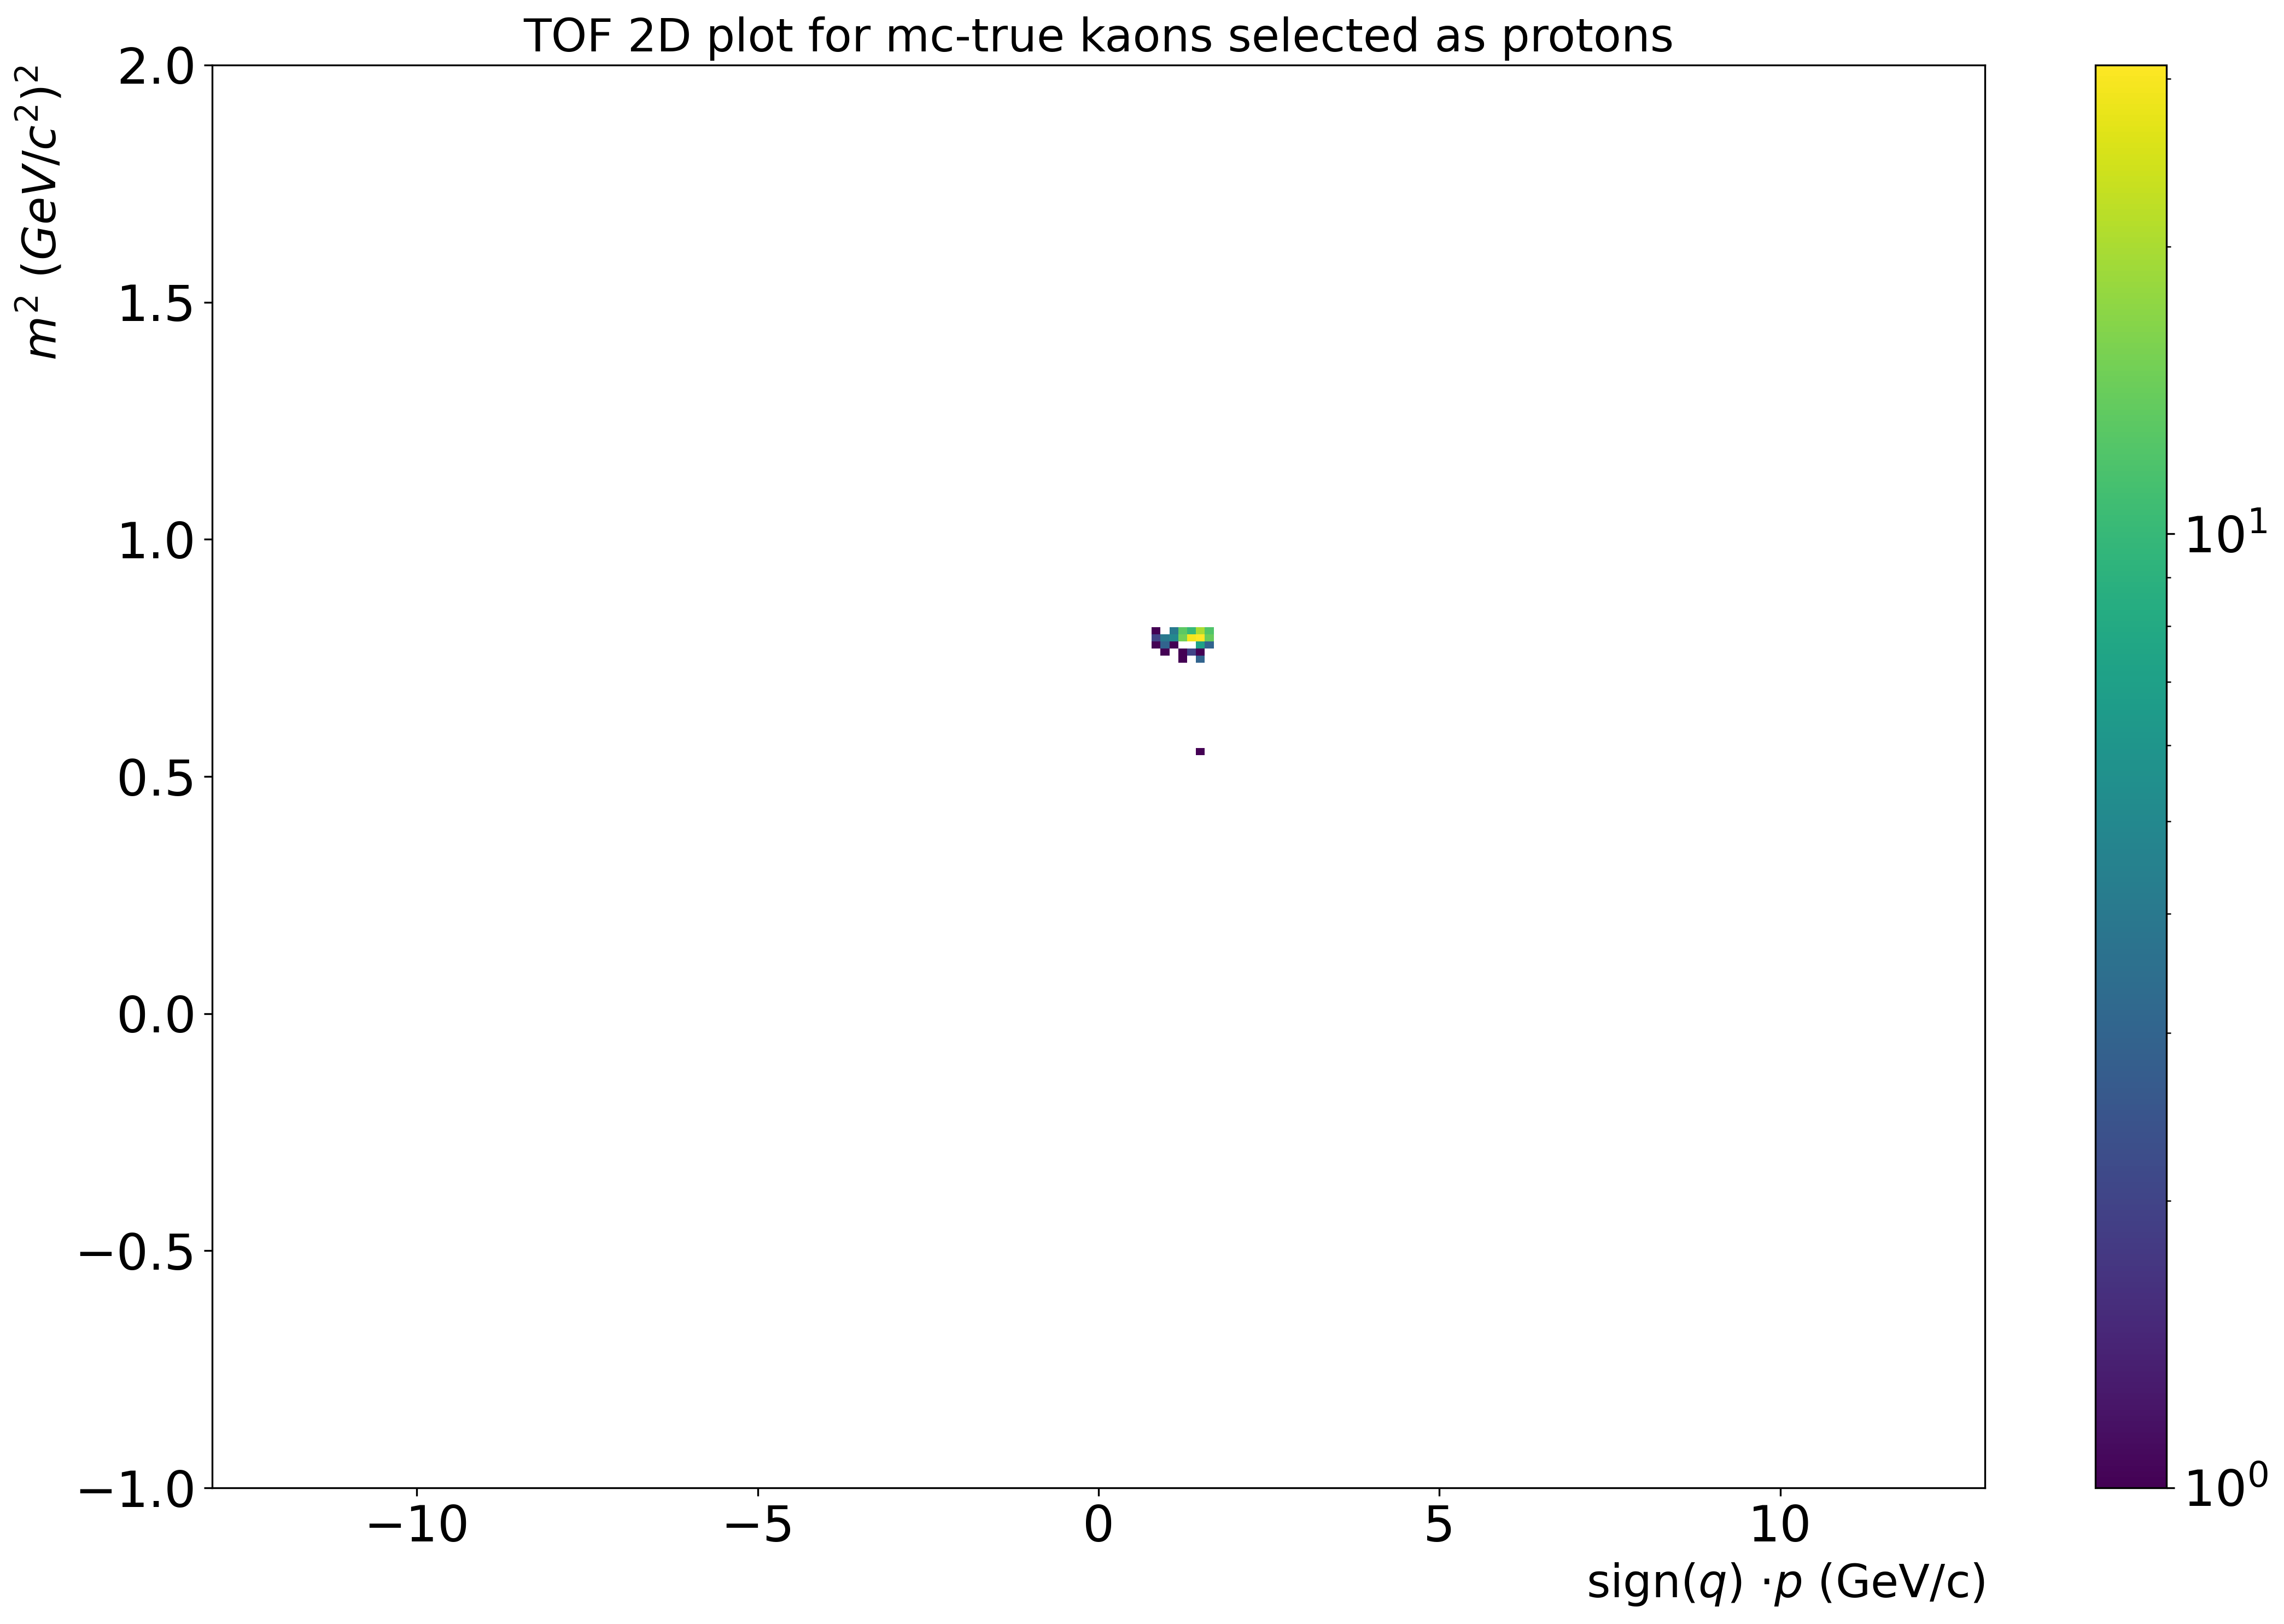

In [7]:
investigate_df = df[(df["xgb_preds"] == 1) & (df["Complex_mass2"] > .5) & (df["Complex_pid"] == 0)]
plotting_tools.tof_plot(
            investigate_df,
            json_file_name,
            f"mc-true kaons selected as protons",
            save_fig=False,
        )

In [8]:
#lets prepare shap explainer
features_for_train = json_tools.load_features_for_train(json_file_name)
model_hdl = ModelHandler()
model_hdl.load_model_handler(model_name)
feature_names = [item.replace("Complex_", "") for item in features_for_train]
explainer = shap.TreeExplainer(
        model_hdl.get_original_model(), n_jobs=8, approximate=False
    )
shap_values = explainer.shap_values(investigate_df[features_for_train])

Let's take a look at the first, random particle in this group

In [9]:
investigated_row = investigate_df.head(1)
investigated_row

,Complex_E,Complex_T,Complex_chi2_ov_ndf_vtx,Complex_eta,Complex_l,Complex_mass,Complex_mass2,Complex_p,Complex_pT,Complex_phi,...,Complex_vtx_chi2,Complex_M,Complex_id,Complex_mother_id,Complex_pid,Complex_q,model_output_0,model_output_1,model_output_2,xgb_preds
44730,1.724418,0.786146,0.568624,5.505458,766.472656,0.938272,0.795193,1.446811,0.011764,0.328769,...,0.337411,198.0,62.0,-1.0,0.0,1.0,0.480285,0.519318,0.000397,1


And especially its values which are used for training

In [10]:
investigated_row[features_for_train]

,Complex_mass2,Complex_eta,Complex_phi,Complex_vtx_chi2,Complex_chi2_ov_ndf_vtx
44730,0.795193,5.505458,0.328769,0.337411,0.568624


In [11]:
data = investigated_row[features_for_train].iloc[0]

lets check probability of this particle being a kaon

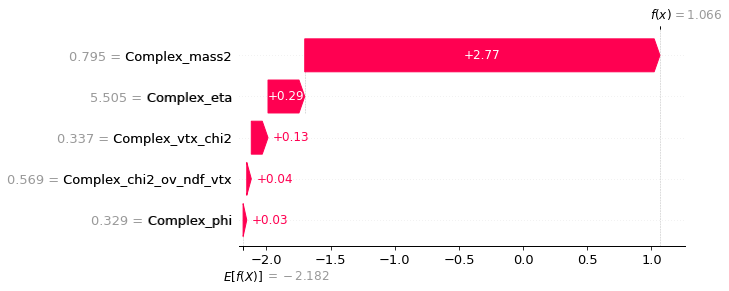

In [12]:
shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=data,
            feature_names=features_for_train,
        )
    )
)

And now being a proton

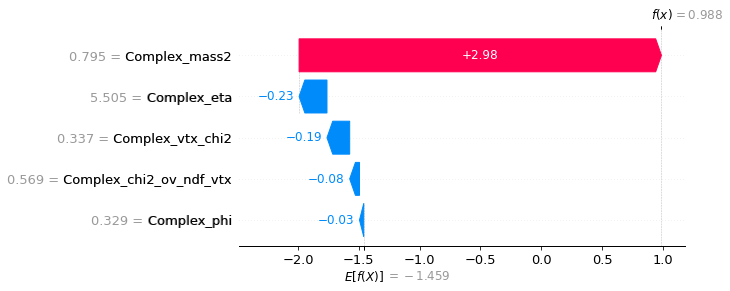

In [13]:

shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[0][0],
            base_values=explainer.expected_value[0],
            data=data,
            feature_names=features_for_train,
        )
    )
)

The probability of given particle being a kaon is only slightly higher than a proton, mostly caused by the geometry of the event (i.e. high $\eta$)

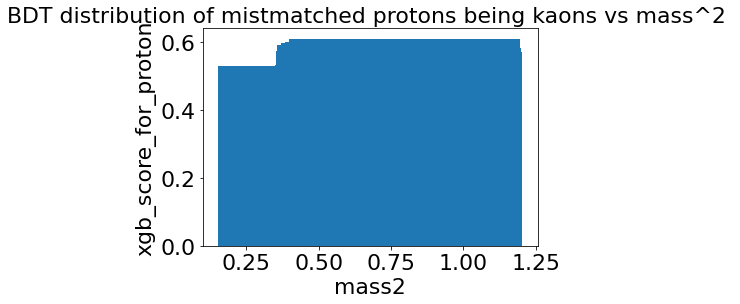

In [14]:
plt.bar(investigate_df["Complex_mass2"], investigate_df["model_output_1"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of mistmatched protons being kaons vs mass^2 ")
plt.show()

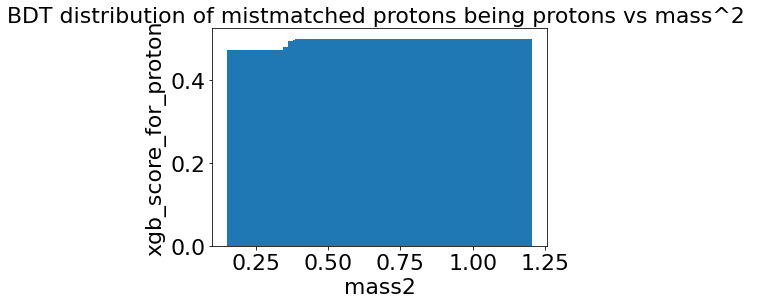

In [15]:
plt.bar(investigate_df["Complex_mass2"], investigate_df["model_output_0"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of mistmatched protons being protons vs mass^2 ")
plt.show()

In [16]:
protons = df[df["Complex_pid"] == 0].sample(10000)
kaons = df[df["Complex_pid"] == 1].sample(10000)

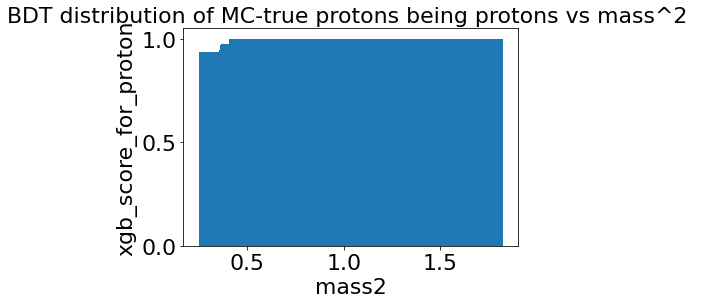

In [17]:
plt.bar(protons["Complex_mass2"], protons["model_output_0"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of MC-true protons being protons vs mass^2 ")
plt.show()

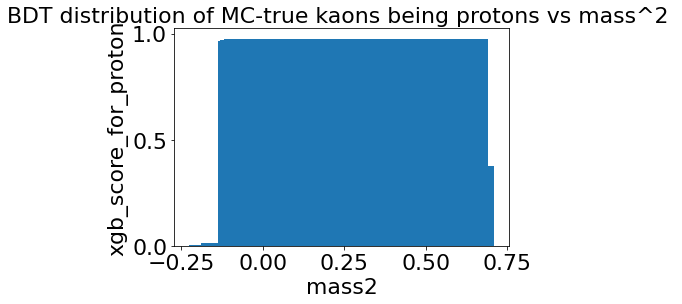

In [18]:
plt.bar(kaons["Complex_mass2"], kaons["model_output_0"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of MC-true kaons being protons vs mass^2 ")
plt.show()

In [19]:
plt.bar(kaons["Complex_mass2"], kaons["model_output_1"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of MC-true kaons being kaons vs mass^2 ")
plt.show()